## TP4: Analyse de données (suite): clustering

Dans ce TP l'objectif est d'implémenter un type d'analyse de données de façon non supervisée en faisant du "clustering", 
c'est à dire en cherchant des groupes de données qui se ressemblent, sans information préalable sur leurs catégories

Par exemple si on observe ces points en deux dimensions, on peut distinguer trois groupes relativement séparés
<img src="TP/cluster_init3.png">

Un algorithme de clustering est un algorithme qui est censé repérer ces groupes, éventuellement en supposant le nombre de groupes à chercher. 

In [2]:
%matplotlib inline
from IPython.display import Image

On utilisera le même module graphique qu'au TP3

In [3]:
import matplotlib.pyplot as plt

### Première partie: la méthodes des k moyennes

Vous allez implémenter la méthodes des k moyennes sur des données artificielles, en utilisant la fonction qui génère des nuages de point du TP3

Cet algorithme suit le principe suivant, en présupposant qu'on fixe le nombre de groupes $k$

    - tirer au hasard k points dans l'espace voulu: ce seront les centres des clusters
    - répéter jusqu'à convergence 
        - assigner chaque point au cluster dont le centre est le plus proche
        - recalculer les centres des clusters: le nouveau centre est le barycentre des points du cluster (moyenne)
        
Un critère de convergence classique est de voir que la différence des distances des centres des clusters devient négligeable. On peut aussi fixer un nombre maximal d'itérations, mais ce n'est pas du tout optimal. 

Indice: Vous pouvez utiliser numpy pour simplifier certains calculs. 




Voici ce que donnerait un exemple d'éxécution sur les données ci-dessus, en choississant 2, 3 ou 4 clusters. Ici les couleurs sont assignées à chaque cluster repéré, pour faciliter la visualisation.  

<table>
    <tr>
    <td> <img src="TP/kmeans_3_2.png" width="400"></td>
    <td> <img src="TP/kmeans_3_3.png" width="400"></td>
      <td>   <img src="TP/kmeans_3_4.png" width="400"></td>
    </tr>
</table>

La croix indique le centre calculé pour chaque cluster. 

<strong> Attention </strong>: on génère des blobs pour avoir un exemple, mais évidemment l'algorithme de k-means n'a aucune information sur l'origine des données: il ne voit que l'ensemble total de tous les points. Vous pouvez générer n'importe quel nombre n de blobs, et tester les k-means avec k=ce que vous voulez (2, 3, 15, ...). 

Voici une version possible avec numpy pour la fonction blob du TP3, qui renvoie une matrice numpy:
    

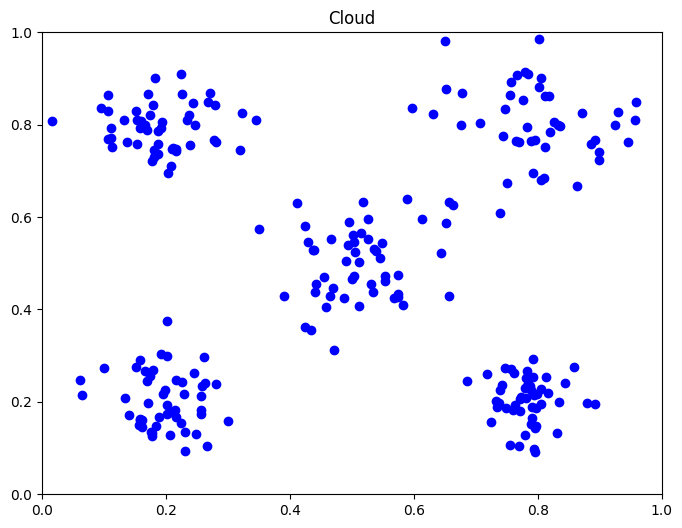

IndexError: list index out of range

In [41]:
import numpy as np
import random
def blob(x0,y0,n,scale=1.):
    """
    nuage de points autour de (x,y)
    """   
    return np.random.normal((x0,y0),scale,size=(n,2))

def euclidean_dist(point1, point2):
    return np.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)

def take_k_points(kp,cloud) :

    return (random.choices(cloud,k=kp))

def clusters(kp, cloud) :
    """kp : nb of mids
        The fonction create clusters with kp random points  """

    mids=take_k_points(kp,cloud)
    cloud_clustered =dict()
    for key in mids :
        cloud_clustered[tuple(key)] = []


    for point in cloud:
        dist = float('inf')
        closest_mid = None
     
        for k in mids:
            current_d = euclidean_dist(k, point)
            if current_d < dist:
                dist = current_d
                closest_mid = k
        
        cloud_clustered[tuple(closest_mid)].append(point)
        

    return cloud_clustered

def barycentre(cloud):
    if not cloud:  
        return (0, 0)
    sum_x = 0
    sum_y = 0
    for point in cloud :
        sum_x += point[0]
        sum_y += point[1]

    n=len(cloud)
    bary_x = sum_x/n    
    bary_y = sum_y/n

    return (bary_x,bary_y)

def recalculate_centers(cloud_clustered):
    """barycentred clusters
    return new and old cloud"""
    new_centers_dict = dict()

    for key in list(cloud_clustered.keys()):#list() needed
        
        bary = barycentre(cloud_clustered[key])  


        new_centers_dict[bary] = cloud_clustered[key]

    return new_centers_dict

def plot_clusters(cloud_clustered):

    colors = plt.cm.get_cmap('viridis', len(cloud_clustered))

    plt.figure(figsize=(10, 6))

    for indexx, (middle, points) in enumerate(cloud_clustered.items()):
        points = np.array(points) 
        plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {indexx + 1}', color=colors(indexx))  # Plot points

        # middles
        plt.scatter(*middle, color='black', marker='x', s=100, label=f'k points {indexx + 1}')

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    plt.title('Clustered Points Visualization')
    plt.legend()

    plt.grid()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
   
def evaluate_xith_cond(cloud_clustered, old_cloud_clustered, seuil=0.05, wanted_precision=0.9):
    """Evaluate the closeness of current cluster centers to the previous centers."""
    nb_keys = len(cloud_clustered)
    total_accuracy = 0

    for i in range(nb_keys):
        current_key = list(cloud_clustered.keys())[i]
        old_key = list(old_cloud_clustered.keys())[i]
        
        dist = euclidean_dist(current_key, old_key)
        
        accuracy_current = max(0, 1 - dist / seuil)
        total_accuracy += accuracy_current

    average_accuracy = total_accuracy / nb_keys
    is_good = average_accuracy >= wanted_precision

    return is_good, average_accuracy

def learn_until_good(cloud,kp) :
    cloud_clustered=clusters(kp,cloud)
    old_cloud_clustered = { (float('inf'), float('inf')): [] for _ in range(len(cloud_clustered)) }

    
    cpt=0
    for i in range (1000) :
        is_good, avg_accuracy = evaluate_xith_cond(cloud_clustered, old_cloud_clustered)
        if is_good :
            break
        old_cloud_clustered = cloud_clustered.copy()
        cloud_clustered = recalculate_centers(cloud_clustered)

    return cloud_clustered,cpt
        




        
            

    
            
    




#TEST
#cloud base

g1 = blob(0.2, 0.8, 50, scale=0.05)
g2 = blob(0.8, 0.8, 50, scale=0.08)
g3 = blob(0.5, 0.5, 50, scale=0.07)
g4 = blob(0.2, 0.2, 50, scale=0.06)
g5 = blob(0.8, 0.2, 50, scale=0.04)


all_points = np.vstack([g1, g2, g3, g4, g5])#concatenation

plt.figure(figsize=(8, 6))
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.scatter(all_points[:, 0], all_points[:, 1], color='blue', marker='o')

plt.title("Cloud")
plt.grid(False)
plt.show()
#cluster and bary


c=clusters(5,all_points)
plot_clusters(c)

plot_clusters(ccopy_cent)
old_cloud_clustered = { (float('inf'), float('inf')): [] for _ in range(len(cloud_clustered)) }

#j=learn_until_good(all_points,5)
#plot_clusters(j[0])

### Deuxième partie: de "vraies" données

Vous pouvez maintenant utiliser le fichier "iris.txt", du TP 3. 
Rappel: Il contient des caractéristiques de différentes fleurs de l'espèce iris, réparties en trois sous-espèces "setosa", "virginica", "versicolor". 

Vous pouvez utiliser numpy pour lire directement les données: 

In [5]:
%pwd

'c:\\Users\\ocram\\Python\\Tp python 2a\\TP4'

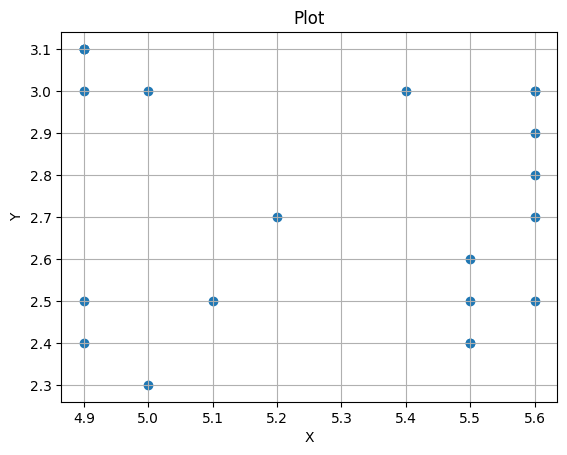

In [6]:
import numpy as np
import random
data = np.genfromtxt('iris.txt', dtype=None,delimiter=',',names=True,encoding="utf8")

def jumbo(data):
    sepal = []
    for i in data :
        sepal.append((i[0],i[1]))

    return sepal
        


def plot_tuples(tuples):
    x_coords, y_coords = zip(*tuples)  
    plt.scatter(x_coords, y_coords)    
    plt.xlabel('X')               
    plt.ylabel('Y')               
    plt.title('Plot')        
    plt.grid(True)                     
    plt.show()                         





def cluster_1center(center,cloud,range):
    """return the list of tuple of the cluster"""
    res =[]
    for point in cloud :
        norm = np.sqrt((point[0] - center[0]) ** 2 + (point[1] - center[1]) ** 2)
        if norm <= range :
            res.append(point)

    return res

cloud = jumbo(data)
clust =cluster_1center(random.choice(cloud), cloud, 0.5)
plot_tuples(clust)



En supposant qu'on ne connait pas la classe de chaque point, lancez kmeans pour voir quels groupes seraient fait automatiquement. Par exemple en cherchant 3 classes sur les données avec seulement les traits "sepal length", "petal width":    


<img src="TP/iris_pw_sl_3.png" width="600">

Vous pouvez comparer aux vraies classes ! (ci-dessous)

<img src="TP/iris_pw_sl_real.png" width="600">

Pour cela (quand on connait les vraies catégories bien sûr) on peut calculer la "pureté" des clusters c'est à dire la proportion de la classe la plus représentée dans chaque cluster, et faire la moyenne sur l'ensemble des classes. 


avec $k$ clusters: $G_1, G_2, ..., G_k$, et pour chaque instance $x_i$ (i dans [1,n]) on a le vrai label du point $l(x_i)$, et C désignant l'ensemble des classes: 

$$ purity(G_j) = \frac{max_{c\in C}  \sum_i l(x_i)=c}{|G_j|}$$



Ecrivez une fonction qui implémente cette mesure sur un ensemble de données: pour chaque point on connait la "vraie" classe, et on a le résultat du clustering. 

NB: On reverra ceci et d'autres méthodes de clustering au 2e semestre dans le cours d'apprentissage. 